# Modèle Naive Bayes

par Ali

## 1. Télechargement des packages nécessaires

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score,precision_score, recall_score

## 2. Importation des ensembles d'entraînement et de test.

In [2]:
with open('Variables/variables.pkl', 'rb') as f:
    (df, X_train, X_test, y_train, y_test,X_train_smote, y_train_smote) = pickle.load(f)

In [3]:
print(df.columns)

Index(['comportement_risqueSexuel', 'comportement_alimentation',
       'comportement_hygienePersonnelle', 'intention_aggrégation',
       'intention_engagement', 'attitude_cohérence', 'attitude_spontanéité',
       'norme_personneImportante', 'norme_accomplissement',
       'perception_vulnérabilité', 'perception_sévérité', 'motivation_force',
       'motivation_volonté', 'soutienSocial_émotionnel',
       'soutienSocial_appréciation', 'soutienSocial_instrumental',
       'autonomisation_connaissance', 'autonomisation_compétences',
       'autonomisation_désirs', 'cancer_colUterus'],
      dtype='object')


In [4]:
print(df.shape)

(72, 20)


## 3. Naive Bayes

Nous avons choisi d'entraîner l'algorithme Naïve Bayes en utilisant trois modèles distincts afin d'évaluer leur pertinence par rapport à la structure de notre dataset.

- GaussianNB est adapté aux variables continues suivant une distribution normale, ce qui nous permet de travailler avec des données numériques continues.

- BernoulliNB est conçu pour des variables binaires (0 ou 1), ce qui le rend pertinent pour des tâches de classification binaire ou d’analyse de texte basée sur la présence ou l’absence de mots.

- MultinomialNB fonctionne avec des variables discrètes et des comptes entiers, un choix idéal pour le traitement du langage naturel (NLP) et l’analyse des fréquences de mots.

En testant ces trois approches, nous pouvons mieux comprendre leur compatibilité avec nos données et identifier le modèle offrant les meilleures performances pour notre problématique.

### 3.1 Entraînement des modèles avec SMOTE


 GaussianNB - Accuracy: 0.90
 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.78      0.88      0.82         8

    accuracy                           0.90        29
   macro avg       0.86      0.89      0.88        29
weighted avg       0.90      0.90      0.90        29

 Matrice de Confusion :
 [[19  2]
 [ 1  7]]

 BernoulliNB - Accuracy: 0.93
 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.88      0.88      0.88         8

    accuracy                           0.93        29
   macro avg       0.91      0.91      0.91        29
weighted avg       0.93      0.93      0.93        29

 Matrice de Confusion :
 [[20  1]
 [ 1  7]]

 MultinomialNB - Accuracy: 0.79
 Rapport de Classification :
               precision    recall  f1-score   support

           0       

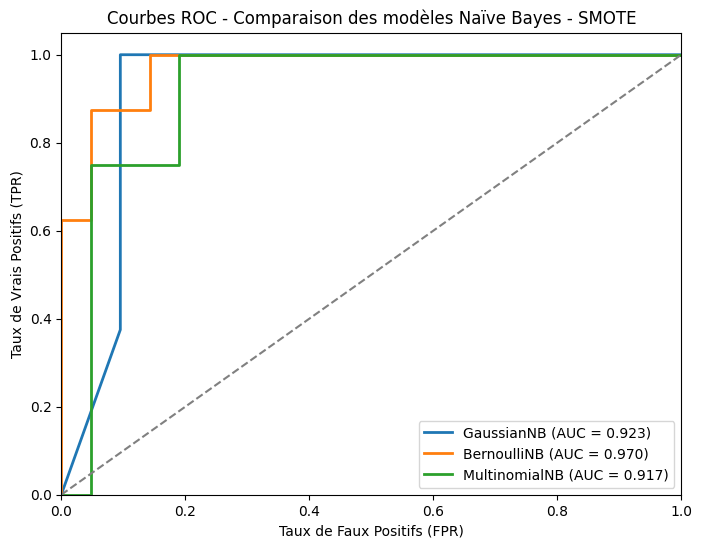


Tableau de comparaison des modèles avec SMOTE :
+---------------+------------+------------+-------------+----------+---------+
| Modèle        |   Accuracy |   F1-Score |   Precision |   Recall |     AUC |
+===============+============+============+=============+==========+=========+
| GaussianNB    |    0.89655 |    0.82353 |     0.77778 |    0.875 | 0.92262 |
+---------------+------------+------------+-------------+----------+---------+
| BernoulliNB   |    0.93103 |    0.875   |     0.875   |    0.875 | 0.97024 |
+---------------+------------+------------+-------------+----------+---------+
| MultinomialNB |    0.7931  |    0.72727 |     0.57143 |    1     | 0.91667 |
+---------------+------------+------------+-------------+----------+---------+


In [5]:
# Initialisation des modèles Naïve Bayes
models = {
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB()
}

# Normalisation : adapte les données pour chaque modèle
scaler_standard = StandardScaler()  # Pour GaussianNB et BernoulliNB (moyenne=0, écart-type=1)
scaler_minmax = MinMaxScaler()      # Pour MultinomialNB (valeurs entre 0 et 1, pas de négatifs)

# Normalisation :
# - StandardScaler : centre les données (moy=0, écart=1), ok pour GaussianNB et BernoulliNB.
# - MinMaxScaler : met tout entre [0,1], requis pour MultinomialNB (pas de valeurs négatives).
# - fit_transform sur train : calcule params et applique.
# - transform sur test : utilise params de train, évite data leakage.
X_train_scaled_standard = scaler_standard.fit_transform(X_train_smote)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train_smote)
X_test_scaled_standard = scaler_standard.transform(X_test)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Entraînement et évaluation des modèles
results_smote = {}
metrics = {} 
table_data = []

for name, model in models.items():
    if name == "MultinomialNB":
        model.fit(X_train_scaled_minmax, y_train_smote)
        y_pred = model.predict(X_test_scaled_minmax)
        y_prob = model.predict_proba(X_test_scaled_minmax)[:, 1]
    else:
        model.fit(X_train_scaled_standard, y_train_smote)
        y_pred = model.predict(X_test_scaled_standard)
        y_prob = model.predict_proba(X_test_scaled_standard)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0) 
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calcul de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Stockage dans results
    results_smote[name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }

    metrics[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }

    # Ajout des nouvelles métriques au tableau
    table_data.append([name, f"{accuracy:.5f}", f"{f1:.5f}", f"{precision:.5f}", f"{recall:.5f}", f"{roc_auc:.5f}"])

    print(f"\n {name} - Accuracy: {accuracy:.2f}")
    print(" Rapport de Classification :\n", report)
    print(" Matrice de Confusion :\n", conf_matrix)

# Affichage des courbes ROC
plt.figure(figsize=(8,6))
for name, res in results_smote.items():
    plt.plot(res["fpr"], res["tpr"], lw=2, label=f'{name} (AUC = {res["auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Comparaison des modèles Naïve Bayes - SMOTE')
plt.legend(loc="lower right")
plt.savefig("../Image/ROC_NB_smote.png")
plt.show()

# Création du tableau comparatif avec les colonnes Precision et Recall
headers = ["Modèle", "Accuracy", "F1-Score", "Precision", "Recall", "AUC"]
print("\nTableau de comparaison des modèles avec SMOTE :")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

### 3.2 Entraînement des modèles sans SMOTE


 GaussianNB - Accuracy: 0.90
 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.78      0.88      0.82         8

    accuracy                           0.90        29
   macro avg       0.86      0.89      0.88        29
weighted avg       0.90      0.90      0.90        29

 Matrice de Confusion :
 [[19  2]
 [ 1  7]]

 BernoulliNB - Accuracy: 0.90
 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.73      1.00      0.84         8

    accuracy                           0.90        29
   macro avg       0.86      0.93      0.88        29
weighted avg       0.92      0.90      0.90        29

 Matrice de Confusion :
 [[18  3]
 [ 0  8]]

 MultinomialNB - Accuracy: 0.76
 Rapport de Classification :
               precision    recall  f1-score   support

           0       

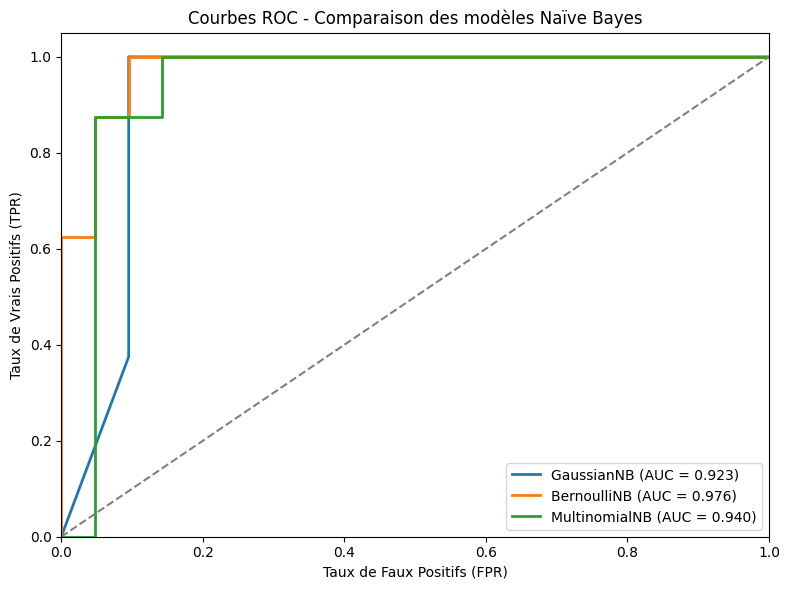


Tableau de comparaison des modèles sans SMOTE :
+---------------+------------+------------+-------------+----------+---------+
| Modèle        |   Accuracy |   F1-Score |   Precision |   Recall |     AUC |
+===============+============+============+=============+==========+=========+
| GaussianNB    |    0.89655 |    0.82353 |     0.77778 |    0.875 | 0.92262 |
+---------------+------------+------------+-------------+----------+---------+
| BernoulliNB   |    0.89655 |    0.84211 |     0.72727 |    1     | 0.97619 |
+---------------+------------+------------+-------------+----------+---------+
| MultinomialNB |    0.75862 |    0.36364 |     0.66667 |    0.25  | 0.94048 |
+---------------+------------+------------+-------------+----------+---------+


In [6]:
# Initialisation des modèles Naïve Bayes
models = {
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB()
}

# Normalisation : adapte les données pour chaque modèle
scaler_standard = StandardScaler()  # Pour GaussianNB et BernoulliNB (moyenne=0, écart-type=1)
scaler_minmax = MinMaxScaler()      # Pour MultinomialNB (valeurs entre 0 et 1, pas de négatifs)

# Normalisation :
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Entraînement et évaluation des modèles
results = {}
metrics = {} 
table_data = []

for name, model in models.items():
    if name == "MultinomialNB":
        model.fit(X_train_scaled_minmax, y_train)
        y_pred = model.predict(X_test_scaled_minmax)
        y_prob = model.predict_proba(X_test_scaled_minmax)[:, 1]
    else:
        model.fit(X_train_scaled_standard, y_train)
        y_pred = model.predict(X_test_scaled_standard)
        y_prob = model.predict_proba(X_test_scaled_standard)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0) 
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calcul de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Stockage dans results
    results[name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }

    metrics[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "y_pred": y_pred
    }

    # Ajout des nouvelles métriques au tableau
    table_data.append([name, f"{accuracy:.5f}", f"{f1:.5f}", f"{precision:.5f}", f"{recall:.5f}", f"{roc_auc:.5f}"])

    print(f"\n {name} - Accuracy: {accuracy:.2f}")
    print(" Rapport de Classification :\n", report)
    print(" Matrice de Confusion :\n", conf_matrix)

# Affichage des courbes ROC
plt.figure(figsize=(8,6))
for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], lw=2, label=f'{name} (AUC = {res["auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC - Comparaison des modèles Naïve Bayes')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../Image/ROC_NB.png")
plt.show()

# Création du tableau comparatif avec les colonnes Precision et Recall
headers = ["Modèle", "Accuracy", "F1-Score", "Precision", "Recall", "AUC"]
print("\nTableau de comparaison des modèles sans SMOTE :")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

## 4. Analyse des modèles Naïve Bayes avec et sans SMOTE

- Amélioration :

  - MultinomialNB : SMOTE améliore fortement ses performances. Accuracy : +6% , F1-score : +100% , AUC reste stable (~0.94)

- Peu d’impact :

  - GaussianNB et BernoulliNB voient leurs résultats légèrement stables ou constants, car ils sont déjà robustes face au déséquilibre ou bien adaptés aux distributions du dataset.

- Conclusion générale :

  - GaussianNB reste stable et performant, sans impact notable de SMOTE.

  - BernoulliNB profite de SMOTE, améliorant la précision globale et maintenant un équilibre parfait entre précision et rappel.

  - MultinomialNB montre une nette amélioration en termes de rappel et F1-Score avec SMOTE, même si cela se fait au détriment de la précision.

##### Comparaison des Modèles Naïve Bayes

Les performances des trois modèles Naïve Bayes ont été évaluées sur notre dataset, tant sans SMOTE qu'avec SMOTE.

Le modèle GaussianNB repose sur l'hypothèse que les variables continues suivent une distribution normale. Dans notre cas, les données numériques semblent se conformer à cette hypothèse, ce qui se traduit par des performances stables tant sans SMOTE qu'avec SMOTE. Avec une accuracy d'environ 0.89655 et une AUC de 0.92262, ce modèle s'avère robuste et bien adapté aux caractéristiques de nos données.

BernoulliNB, quant à lui, est conçu pour les variables binaires. Même si seule la variable cible est binaire, la normalisation de nos données n'induit pas une véritable binarisation des variables explicatives. Toutefois, la structure des caractéristiques de notre dataset, après transformation, semble favoriser ce modèle. Sans SMOTE, BernoulliNB atteint un rappel parfait (Recall = 1), bien que sa précision soit légèrement inférieure. L'application de SMOTE permet de retrouver un équilibre optimal entre précision et rappel, avec des scores améliorés (accuracy 0.93103, F1-Score 0.875, et précision et rappel égales à 0.875).

MultinomialNB est destiné aux variables discrètes, notamment aux comptages. Dans notre contexte, nos variables ne sont pas naturellement des comptages, ce qui explique ses performances initialement faibles (F1-Score de 0.36364 et Recall de 0.25 sans SMOTE). L'utilisation de SMOTE améliore notablement ces indicateurs en augmentant le recall à 1 et le F1-Score à 0.72727, mais cela se fait au détriment de la précision, qui chute à 0.57143. Ce modèle semble donc identifier tous les cas positifs, mais en générant un nombre élevé de faux positifs.

En conclusion, le choix du modèle dépend fortement de la nature des données et des hypothèses sous-jacentes. Le modèle GaussianNB offre des performances stables grâce à son adéquation avec des données continues distribuées normalement. BernoulliNB, particulièrement amélioré par SMOTE, est très performant malgré la binarisation de la cible, probablement en raison d'une structure implicite dans les variables explicatives. Enfin, MultinomialNB est moins adapté aux données qui ne sont pas naturellement discrètes, bien que SMOTE permette d'améliorer certains indicateurs. Ces résultats illustrent l'importance d'adapter le modèle aux caractéristiques spécifiques du dataset pour obtenir des performances optimales.

**Nous décidons de proposer le meilleur modèle (BernoulliNB avec SMOTE) afin de le comparer avec d'autres algorithmes de classification.**


## 5. Exporter les variables

In [7]:
roc_data_NB = {
    'fpr_nb': results_smote["BernoulliNB"]["fpr"],
    'tpr_nb': results_smote["BernoulliNB"]["tpr"],
    'auc_nb': results_smote["BernoulliNB"]["auc"],
    'pred_nb': results_smote["BernoulliNB"]["y_pred"]
}

# Sauvegarder les données dans un fichier pickle
with open('Variables/roc_data_NB.pkl', 'wb') as file:
    pickle.dump(roc_data_NB, file)

print("Les données ROC, AUC et prédictions de BernoulliNB ont été enregistrées dans 'roc_data_NB.pkl'.")

Les données ROC, AUC et prédictions de BernoulliNB ont été enregistrées dans 'roc_data_NB.pkl'.
